In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

RSEED = 42

In [66]:
# Load data
df = pd.read_csv("../data/preprocessed/Building_5.csv").astype({'datetime': 'datetime64'}).set_index('datetime')

In [67]:
# Add a total load with cooling
df['total_load_kWh'] = df['equipment_electric_power_kWh'] + df['dhw_heating_kWh'] + df['cooling_load_kWh']

# Add a total load without cooling
df['total_load_wo_cooling_kWh'] = df['equipment_electric_power_kWh'] + df['dhw_heating_kWh']

# Replace holiday and workday with 0 or 1
df['holiday'] = df['holiday'].replace({True: 1, False: 0})
df['workday'] = df['workday'].replace({True: 1, False: 0})
df['daylight_savings'] = df['daylight_savings'].replace({True: 1, False: 0})


#df['month'] = df['month'].astype('category')
#df['hour'] = df['hour'].astype('category')

df.columns

# df = df.drop('day_type', axis=1)
# df = pd.get_dummies(df, drop_first=True)

df['pred_24h_diffuse_solar_W_m2_shift'] = df['pred_24h_diffuse_solar_W_m2'].shift(periods=24)
df['pred_24h_direct_solar_W_m2_shift'] = df['pred_24h_direct_solar_W_m2'].shift(periods=24)
df['pred_24h_outdoor_temp_shift'] = df['pred_24h_outdoor_temp'].shift(periods=24)
df['pred_24h_outdoor_hum_shift'] = df['pred_24h_outdoor_hum'].shift(periods=24)

# Add a total load
df['total_load_kWh'] = df['equipment_electric_power_kWh'] + df['dhw_heating_kWh'] + df['cooling_load_kWh']

# Add a total load without cooling
df['total_load_wo_cooling_kWh'] = df['equipment_electric_power_kWh'] + df['dhw_heating_kWh']

# Add a net load
df['net_load_kWh'] = df['equipment_electric_power_kWh'] + df['dhw_heating_kWh'] + df['cooling_load_kWh'] - df['solar_generation_kW']

df = df.dropna()

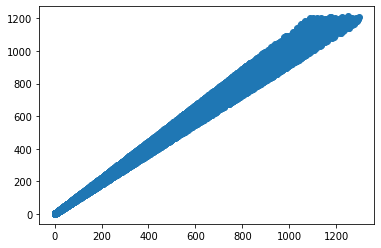

In [68]:
plt.scatter(x=df['pred_24h_direct_solar_W_m2_shift'], y=df['direct_solar_W_m2'])

In [69]:
df.columns

Index(['month', 'hour', 'daylight_savings', 'indoor_temp',
       'avg_unmet_cooling_temp', 'indoor_hum', 'equipment_electric_power_kWh',
       'dhw_heating_kWh', 'cooling_load_kWh', 'solar_generation_W_kW',
       'outdoor_temp', 'outdoor_hum', 'diffuse_solar_W_m2',
       'direct_solar_W_m2', 'pred_6h_outdoor_temp', 'pred_12h_outdoor_temp',
       'pred_24h_outdoor_temp', 'pred_6h_outdoor_hum', 'pred_12h_outdoor_hum',
       'pred_24h_outdoor_hum', 'pred_6h_diffuse_solar_W_m2',
       'pred_12h_diffuse_solar_W_m2', 'pred_24h_diffuse_solar_W_m2',
       'pred_6h_direct_solar_W_m2', 'pred_12h_direct_solar_W_m2',
       'pred_24h_direct_solar_W_m2', 'holiday', 'workday',
       'solar_generation_kW', 'total_load_kWh', 'total_load_wo_cooling_kWh',
       'pred_24h_diffuse_solar_W_m2_shift', 'pred_24h_direct_solar_W_m2_shift',
       'pred_24h_outdoor_temp_shift', 'pred_24h_outdoor_hum_shift',
       'net_load_kWh'],
      dtype='object')

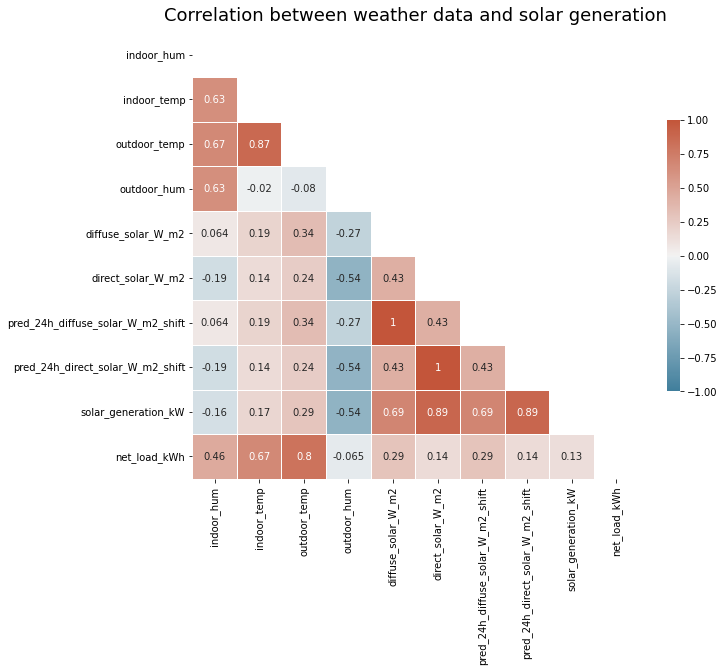

In [70]:
# correlation matrix for weather data + solar generation
fig, ax = plt.subplots(figsize=(10,10))
corr_weather= df[['indoor_hum','indoor_temp','outdoor_temp','outdoor_hum', 'diffuse_solar_W_m2', 'direct_solar_W_m2', 'pred_24h_diffuse_solar_W_m2_shift', 'pred_24h_direct_solar_W_m2_shift', 'solar_generation_kW','net_load_kWh']].corr()
mask = np.triu(np.ones_like(corr_weather, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
heatmap = sns.heatmap(corr_weather, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True)
heatmap.set_title('Correlation between weather data and solar generation', fontdict={'fontsize':18}, pad=12);


### Simple linear regression model using measured weather conditions to predict net energy usage

In [71]:
X = df[['outdoor_temp', 'outdoor_hum', 'diffuse_solar_W_m2', 'direct_solar_W_m2']]
y = df['net_load_kWh']

X = pd.get_dummies(X, drop_first=True)

# Fit linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X, y)

# Calculate r-squared 
y_pred = lin_reg.predict(X)
print("R-squared:", r2_score(y, y_pred).round(3))

coef = lin_reg.coef_
intercept = lin_reg.intercept_

R-squared: 0.653


### Linear regression model with 5 polynomial features to predict net energy usage

In [72]:
rsquared = {"n":[], "rsquared": []}
n = 5
poly = PolynomialFeatures(degree=n, include_bias=False)
poly_features = poly.fit_transform(X)
poly_reg_model = LinearRegression()
poly_reg_model.fit(poly_features, y)
y_pred = poly_reg_model.predict(poly_features)
print("n:", n," R-squared:", r2_score(y, y_pred).round(3))
rsquared["n"].append(n)
rsquared["rsquared"].append(r2_score(y, y_pred).round(3))

coef = poly_reg_model.coef_
intercept = poly_reg_model.intercept_

n: 5  R-squared: 0.808


### Using 24hr weather predictions to calculate net energy usage

In [82]:
X_forecast = df[['pred_24h_outdoor_temp_shift', 'pred_24h_outdoor_hum_shift', 'pred_24h_diffuse_solar_W_m2_shift', 'pred_24h_direct_solar_W_m2_shift']]
y_forecast = df['net_load_kWh']

X_forecast = pd.get_dummies(X_forecast, drop_first=True)

poly_features = poly.fit_transform(X_forecast)
y_pred = poly_reg_model.predict(poly_features)

# Calculate r-squared 
print("R-squared:", r2_score(y_forecast, y_pred).round(3))

df['net_load_kWh_forecast'] = y_pred

R-squared: 0.787


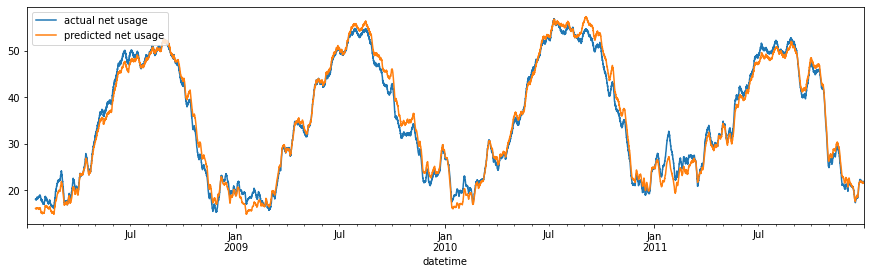

In [85]:
fig, ax = plt.subplots(figsize=(15,4))
df['net_load_kWh'].rolling(365).mean().plot(label="actual net usage")
df['net_load_kWh_forecast'].rolling(365).mean().plot(label="predicted net usage")
plt.legend(loc='upper left')